### On Decision Tree Classifier

### Implementing Equation 18.5 

The goal of a Decision Tree is to find feature $j_i$ and threshold $t_i$ that minimizes the weighted sum of the cost of Left Subtree $c(D^L_i(j,t))$ and Right Subtree $c(D^R_i(j,t))$

Or more precisely
> $(j_i, t_i) = \arg \min_{j \in \{1,..,D\}} \min_{t \in T_j} \frac{|D^L_i (j,t)|}{|D_i|} c(D^L_i(j,t)) + \frac{|D^R_i (j,t)|}{|D_i|} c(D^R_i(j,t))$

We're implementing the equation above.

### Cost Function for Decision Trees

#### Preliminary: Empirical Distribution across different Classes

$\hat{\pi_{ic}} = \frac{1}{ | D_i |} \sum_{n \in D_i}\mathbb{ I(y_n = c) }$

#### Cost Function #1: Gini Index

Using Empirical Distribution, we can calculate the **Gini Index**

$G_i = \sum_{c=1}^{C} \hat{\pi_{ic}} (1 - \hat{\pi_{ic}}) = \sum_{c=1}^C \hat{\pi_{ic}} - \sum_{c=1}^C \hat{\pi_{ic}}^2 = 1 - \sum_{c=1} \hat{\pi_{ic}}^2$

#### Cost Function #2: Entropy

Also, we're also allowed to calculate the **Entropy** of each sample splits.

$H_i = H(\hat{\pi_{ic}}) = -\sum_{c=1}^{C} \hat{\pi_{ic}} \space log \space \hat{\pi_{ic}}$

In [3]:
from dataclasses import dataclass
from sklearn.datasets import load_iris
import numpy as np

In [109]:
def get_one_hot_encode(y):
    num_categories = np.unique(y).shape[0]
    return np.eye(num_categories)[y], num_categories

def stack_target_wrt_thresh(y_one_hot, unique_thresholds):
    num_thresholds = unique_thresholds.shape[1]
    return np.stack(num_thresholds * [y_one_hot], axis=1)

def get_unique_thresholds(X, feature_index):
    return np.unique(X[:,feature_index]).reshape(1,-1)


def get_left_right_samplers(X, unique_thresholds, feature_index):
    selected_features = X[:, feature_index].reshape(-1,1)
    left_sampler = selected_features <= unique_thresholds
    right_sampler = ~left_sampler
    return left_sampler, right_sampler

def get_class_probabilities(y_one_hot_3d, sampler_mask, num_categories):
    with np.errstate(divide='ignore', invalid='ignore'):
        sampler_mask_3d = np.stack(num_categories * [sampler_mask], axis=2)
        sampled = sampler_mask_3d * y_one_hot_3d
        num_samples = np.sum(sampler_mask, axis=0)
        num_samples = np.stack(num_categories * [ num_samples ], axis=1)
        indicator_sum = np.sum(sampled, axis=0)
        class_probs = np.where(num_samples == 0, 0, indicator_sum / num_samples)
        return class_probs, num_samples 

def get_gini_index(class_probs):
    return 1 - np.sum(class_probs ** 2, axis=1)

def get_entropy(class_probs):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_prob = np.where(class_probs > 0.0, 1 / class_probs, 0.0)
        log_prob = np.where(inv_prob > 0.0, np.log2(inv_prob), 0.0)
        return np.sum(class_probs * log_prob, axis=1)
    
def get_weighted_sum(left, right, num_samples_left, num_samples_right):
    total_samples = num_samples_left[:,0] + num_samples_right[:,0]
    left_ratio = num_samples_left[:,0] / total_samples
    right_ratio = num_samples_right[:,0] / total_samples
    weighted_sum = left_ratio * left + right_ratio * right
    return weighted_sum

def get_min_cost(weighted_costs):
    print('weighted_costs.shape = ', weighted_costs.shape)
    min_index = np.argmin(weighted_costs)
    min_cost = weighted_costs[min_index]
    return min_cost, min_index

def get_partition(sampler, min_threshold_index):
    partition = sampler[:, min_threshold_index]
    partition_count = np.sum(partition)
    return partition, partition_count

def get_output_per_node(y, partition):
    y_one_hot, num_categories = get_one_hot_encode(y)

    partition_per_cat = np.stack(num_categories * [partition], axis=1)
    y_one_hot_partitioned = y_one_hot * partition_per_cat
    return np.argmin(np.sum(y_one_hot_partitioned, axis=0))

In [110]:
@dataclass
class SplitData:
    """
    A dataclass for representing the result of a data split at a Decision Tree node, including details necessary for propagating splits across the tree.

    Attributes:
        left_partition_mask (np.ndarray): A boolean mask indicating samples allocated to the left child node based on the split.
        right_partition_mask (np.ndarray): A boolean mask indicating samples allocated to the right child node based on the split.
        left_count (int): Number of samples in the left partition, facilitating efficient calculation of statistics or further splits.
        right_count (int): Number of samples in the right partition, facilitating efficient calculation of statistics or further splits.
        feat_index (int): Index of the feature used for splitting, enabling traceability of the decision path within the tree.
        cost (float): The cost or impurity reduction achieved by this split, used to assess the quality of the split.
        thresh (float): Threshold value for the feature at this split, determining the boundary between left and right partitions.
        
    This structure is crucial for the iterative construction and analysis of Decision Trees, where each node's decision to split data affects subsequent nodes' decisions.
    """
    partition_left: np.ndarray
    partition_right: np.ndarray
    partition_count_left: int
    partition_count_right: int 
    feature_index: int 
    cost: float
    thresh: float
    cost_left: float    # For Debugging
    cost_right: float   # For Debugging

    def __str__(self):
        cost_rounded = float(self.cost)
        cost_rounded = round(cost_rounded, 3)

        left_cost_rounded = float(self.cost_left)
        left_cost_rounded = round(left_cost_rounded, 3)
        
        right_cost_rounded = float(self.cost_right)
        right_cost_rounded = round(right_cost_rounded, 3)

        thresh_rounded = float(self.thresh)
        thresh_rounded = round(thresh_rounded, 3)

        return ', '.join([
            f'cost={cost_rounded}',
            f'left_cost={left_cost_rounded}',
            f'right_cost={right_cost_rounded}',
            f'feature_index={self.feat_min_index}', 
            f'left_count={self.partition_count_left}',
            f'right_count={self.partition_count_right}', 
            f'thresh={thresh_rounded}',
        ])
    

### Calculation of Cost

For classification, we first compute the empirical distribution over class labels for this node: 

$\hat{\pi_{ic}} = \frac{1}{ | D_i |} \sum_{n \in D_i}\mathbb{ I(y_n = c) }$

Given this, we can then compute the **Gini Index**

$G_i = \sum_{c=1}^{C} \hat{\pi_{ic}} (1 - \hat{\pi_{ic}}) = \sum_{c=1}^C \hat{\pi_{ic}} - \sum_{c=1}^C \hat{\pi_{ic}}^2 = 1 - \sum_{c=1} \hat{\pi_{ic}}^2$

In [111]:
class TreeNode:

    def __init__(self, 
                    X : np.ndarray, 
                    y : np.ndarray,
                    max_depth=5, 
                    min_leaves=1,
                    depth_index=0,
                    width_index=0,
                    node_type='init_node',
                    feat_index=0,
                    partition=None,
                    thresh=None
                 ):
        
        self.depth_index = depth_index
        self.width_index = width_index

        self.max_depth = max_depth 
        self.min_leaves = min_leaves
        self.node_type = node_type

        if partition is None:
            self.partition = np.ones((y.shape[0],))
            self.num_samples = y.shape[0]
            self.thresh = np.max(X[:,0])
            self.feat_index = 0
        else:
            self.partition = partition
            self.num_samples = np.sum(partition)
            self.thresh = thresh
            self.feat_index = feat_index

        # self.out_per_node = np.sum(y * self.partition) / self.num_samples
        self.out_per_node = get_output_per_node(y, self.partition)
        split_data = self.split_by_min_feat_thresh(X, y, partition)

        # print(f'({self.depth_index}/{self.width_index}) node_type={self.node_type}, out_per_node={self.out_per_node}, split_data:\n', split_data)
        next_depth = self.depth_index + 1
        is_not_max_depth = self.max_depth > next_depth  
        
        grow_left = min_leaves <= split_data.partition_count_left
        grow_right = min_leaves <= split_data.partition_count_right

        self.left_node, self.right_node = None, None
        
        if is_not_max_depth:
            if grow_left:
                self.left_node = TreeNode(
                                X, y, 
                                max_depth=max_depth, 
                                min_leaves=min_leaves,
                                depth_index=next_depth,
                                width_index=self.width_index,
                                node_type='left_node',
                                feat_index=split_data.feat_min_index,
                                partition=split_data.partition_left,
                                thresh=split_data.thresh,
                            )

        if is_not_max_depth:
            if grow_right:
                self.right_node = TreeNode(
                                X,y,
                                max_depth=max_depth, 
                                min_leaves=min_leaves,
                                depth_index=next_depth,
                                width_index=self.width_index + 1,
                                node_type='right_node',
                                feat_index=split_data.feat_min_index,
                                partition=split_data.partition_right,
                                thresh=split_data.thresh
                            )
    
    def split_by_min_thresh(self, X, y, 
                            feature_index, 
                            cost_func=get_gini_index, 
                            partition=None
                        ):
        unique_thresholds = get_unique_thresholds(X, feature_index) 
        left_sampler, right_sampler = get_left_right_samplers(
                                            X, 
                                            unique_thresholds, 
                                            feature_index
                                        )
        
        if partition is not None:
            partition = np.hstack(left_sampler.shape[1] * [ partition.reshape(-1,1) ])
            left_sampler = left_sampler & partition
            right_sampler = right_sampler & partition

        y_one_hot, num_categories = get_one_hot_encode(y)
        y_one_hot_3d = stack_target_wrt_thresh(y_one_hot, unique_thresholds)

        class_probs_left, num_samples_left = get_class_probabilities(y_one_hot_3d, left_sampler, num_categories)
        class_probs_right, num_samples_right = get_class_probabilities(y_one_hot_3d, right_sampler, num_categories)

        cost_left = cost_func(class_probs_left)
        cost_right = cost_func(class_probs_right)
            
        weighted_costs = get_weighted_sum(cost_left, cost_right, num_samples_left, num_samples_right)
        min_cost, feat_min_index = get_min_cost(weighted_costs)
        partition_left, partition_count_left = get_partition(left_sampler, feat_min_index)
        partition_right, partition_count_right = get_partition(right_sampler, feat_min_index)
        min_thresh = unique_thresholds[0, feat_min_index]

        return SplitData(
            partition_left=partition_left,
            partition_right=partition_right,
            partition_count_left=partition_count_left,
            partition_count_right=partition_count_right,
            feat_min_index=feat_min_index,
            cost=min_cost,
            thresh=min_thresh,
            cost_left=cost_left[feat_min_index],
            cost_right=cost_right[feat_min_index],
        )

    # Splits while finding the minimum feature index
    def split_by_min_feat_thresh(self, X, y, partition):
        feat_count = X.shape[1]
        min_split_data = self.split_by_min_thresh(X, y, 0, 
                                                  cost_func=get_gini_index, 
                                                  partition=partition)

        for feat_index in range(1, feat_count):
            split_data = self.split_by_min_thresh(X, y, feat_index, cost_func=get_gini_index, 
                                                  partition=partition)
            if min_split_data.cost > split_data.cost:
                min_split_data = split_data

        return min_split_data
    
    def prediction_per_node(self, X, y_preds, prev_mask=None):
        print('self.thesh = ', self.thresh)
        print('self.feat_index = ', self.feat_index)
        print('X.shape = ', X.shape)
        if self.node_type == 'right_node':
            prediction_mask = X[:, self.feat_index] > self.thresh
        else:
            prediction_mask = X[:,self.feat_index] <= self.thresh
        
        if prev_mask is not None:
            prediction_mask = prediction_mask & prev_mask

        prediction_indices = np.nonzero(prediction_mask)[0]
        y_preds[prediction_indices] = self.out_per_node
        
        if self.left_node is not None:
            self.left_node.prediction_per_node(X, y_preds, prev_mask=prediction_mask)
        
        if self.right_node is not None:
            self.right_node.prediction_per_node(X, y_preds, prev_mask=prediction_mask)



In [112]:
class DumbDecisionTreeClassifier:
    def __init__(
            self,
            max_depth=5, 
            min_leaves=1, 
        ):
        self.max_depth=max_depth
        self.min_leaves=min_leaves

    def fit(self, X, y):
        # feature_importances = np.zeros(X.shape[1],)
        self.node = TreeNode(X, y, 
                             max_depth=self.max_depth, 
                             min_leaves=self.min_leaves, 
                             depth_index=0
                            )
        
        # self.feature_importances_ = feature_importances / np.sum(feature_importances)
        
    def predict(self, X):
        y_preds = np.zeros((X.shape[0],))
        self.node.prediction_per_node(X, y_preds, prev_mask=None)
        return y_preds

In [113]:
data = load_iris()
X,y = data['data'], data['target']

max_depth = 22
min_leaves = 1

model = DumbDecisionTreeClassifier(max_depth=max_depth, min_leaves=min_leaves)
model.fit(X,y)

weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_costs.shape =  (23,)
weighted_costs.shape =  (43,)
weighted_costs.shape =  (22,)
weighted_costs.shape =  (35,)
weighted_c

In [114]:
import matplotlib.pyplot as plt

y_preds = model.predict(X)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(y.shape[0]), y, linestyle='solid', label='target')
plt.plot(np.arange(y.shape[0]), y_preds, linestyle='dashed', label='dtree_preds')
plt.legend()
plt.title('Target VS DumbDecisionTreePrediction')
plt.ylabel('Output')
plt.xlabel('Instance Sample')
plt.show()

self.thesh =  7.9
self.feat_index =  0
X.shape =  (150, 4)
self.thesh =  1.9
self.feat_index =  8
X.shape =  (150, 4)


IndexError: index 8 is out of bounds for axis 1 with size 4

### Note:
- It's less likely to have a minimum possible depth since the Dataset have imbalanced splits.

In [236]:
import math

min_possible_depth = math.ceil(math.log2(X.shape[0]))
print('min_possible_depth = ', min_possible_depth)


min_possible_depth =  9


In [237]:
count_eq = 0

for v in zip(y, y_preds):
    # print(v)
    count_eq += int(v[0] == v[1])

print('total ratio: ', count_eq / y_preds.shape[0])
print('total mismatch = ', y_preds.shape[0] - count_eq, 'total_count = ', y_preds.shape[0])

total ratio:  1.0
total mismatch =  0 total_count =  442


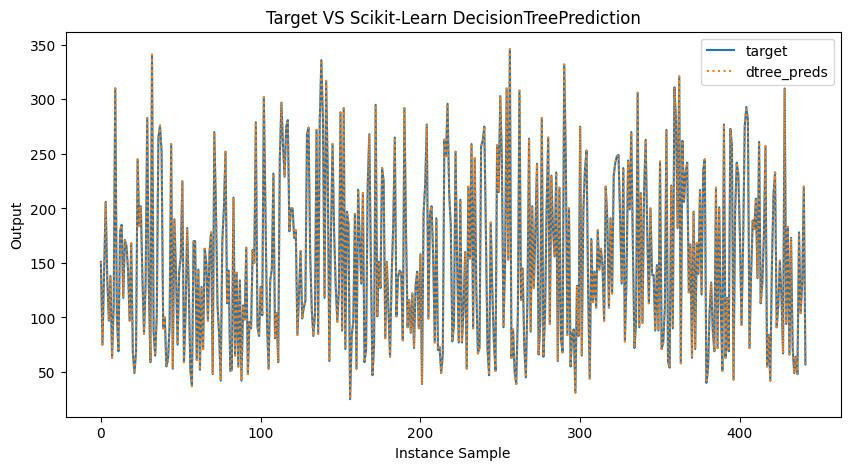

In [238]:
from sklearn.tree import DecisionTreeRegressor

model_sklearn = DecisionTreeRegressor()
model_sklearn.fit(X,y)

y_preds_sklearn = model_sklearn.predict(X)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(y.shape[0]), y, linestyle='solid', label='target')
plt.plot(np.arange(y.shape[0]), y_preds_sklearn, linestyle='dotted', label='dtree_preds')
plt.legend()
plt.title('Target VS Scikit-Learn DecisionTreePrediction')
plt.ylabel('Output')
plt.xlabel('Instance Sample')
plt.show()

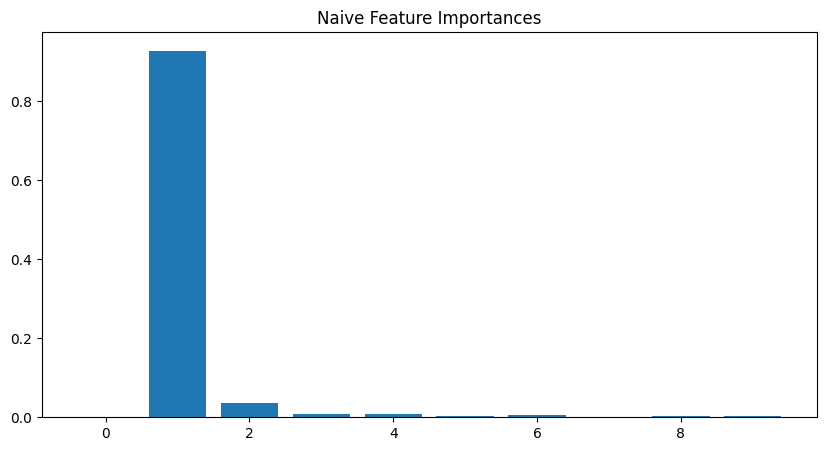

In [244]:
plt.figure(figsize=(10, 5))
plt.bar(np.arange(model.feature_importances_.shape[0]), model.feature_importances_)
plt.title('Naive Feature Importances')
plt.show()

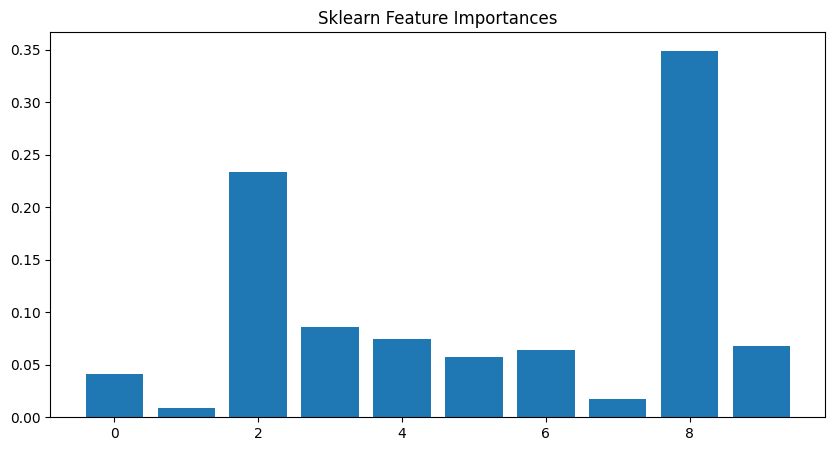

In [245]:
plt.figure(figsize=(10, 5))
plt.bar(np.arange(model_sklearn.feature_importances_.shape[0]), model_sklearn.feature_importances_)
plt.title('Sklearn Feature Importances')
plt.show()

In [95]:
print(model_sklearn.get_depth())

count_eq = 0

for v in zip(y, y_preds_sklearn):
    count_eq += int(v[0] == v[1])

print('total ratio: ', count_eq / y_preds_sklearn.shape[0])
print('total mismatch (sklearn) = ', y_preds.shape[0] - count_eq, 'total_count = ', y_preds.shape[0])

20
total ratio:  1.0
total mismatch (sklearn) =  0 total_count =  442


### Correct Depth Logic

```python

    next_depth = self.depth_index + 1
    is_not_max_depth = self.max_depth > next_depth     
``` 

### Error
1. Sklearn's implementation managed to memorize the dataset with only 20 depth. It heavily implies that we have incorrect stopping criterion.
- In our implementation, the minimum depth that memorizes the whole dataset is 22. One clue in the bug is that it keeps growing if you set it as 30. In other words, our implementation's bug is pretty subtle.